# NIH Chest X-ray Dataset

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

## National Institutes of Health Chest X-Ray Dataset

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

### Data limitations:
- 1. The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
 - 2. Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
 - .Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/nih-chest-xrays/data/home <br>
Research paper : http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf <br>
Research paper : https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ <br>
Research paper : https://arxiv.org/pdf/1711.05225.pdf <br>
Blog : https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

- 1. No strict latency constraints.

<h2> 2.1 Data </h2>

### File contents
Image format: 112,120 total images with size 1024 x 1024

**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h

**Data_entry_2017.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y

**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia



### Goal

The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the flow_from_dataframe to deal with messier datasets


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading </h2>

In [2]:
# reading the data
data = pd.read_csv("../input/Data_Entry_2017.csv")
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
print('shape of data : ',data.shape)

shape of data :  (112120, 12)


In [5]:
data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


<h2> 3.2 Data cleaning </h2>

In [6]:
#drop unused columns
data = data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# removing the rows which have patient_age >100
total = len(data)
print('No. of rows before removing rows having age >100 : ',len(data))
data = data[data['Patient Age']<100]
print('No. of rows after removing rows having age >100 : ',len(data))
print('No. of datapoints having age > 100 : ',total-len(data))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [7]:
# rows having no. of disease
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

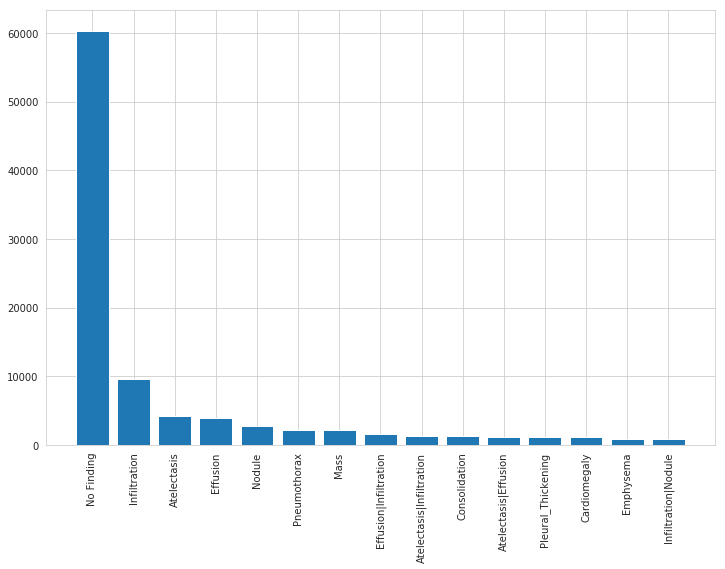

In [8]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

<h2> 3.3 Data analysis </h2>

<h3> 3.3.1 Age distribution </h3>

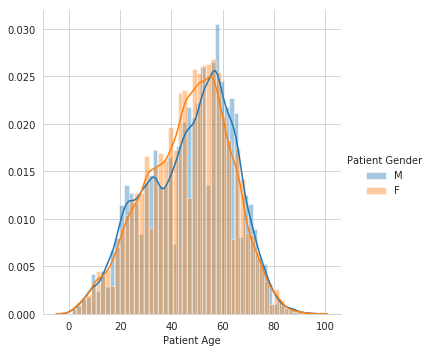

In [9]:
#plt.figure(figsize=(20,15))
sns.FacetGrid(data,hue='Patient Gender',size=5).map(sns.distplot,'Patient Age').add_legend()
plt.show()

#### Observation - Both the gender have almost same distribution

<h3> 3.3.2 Disease distribution by age and sex </h3>

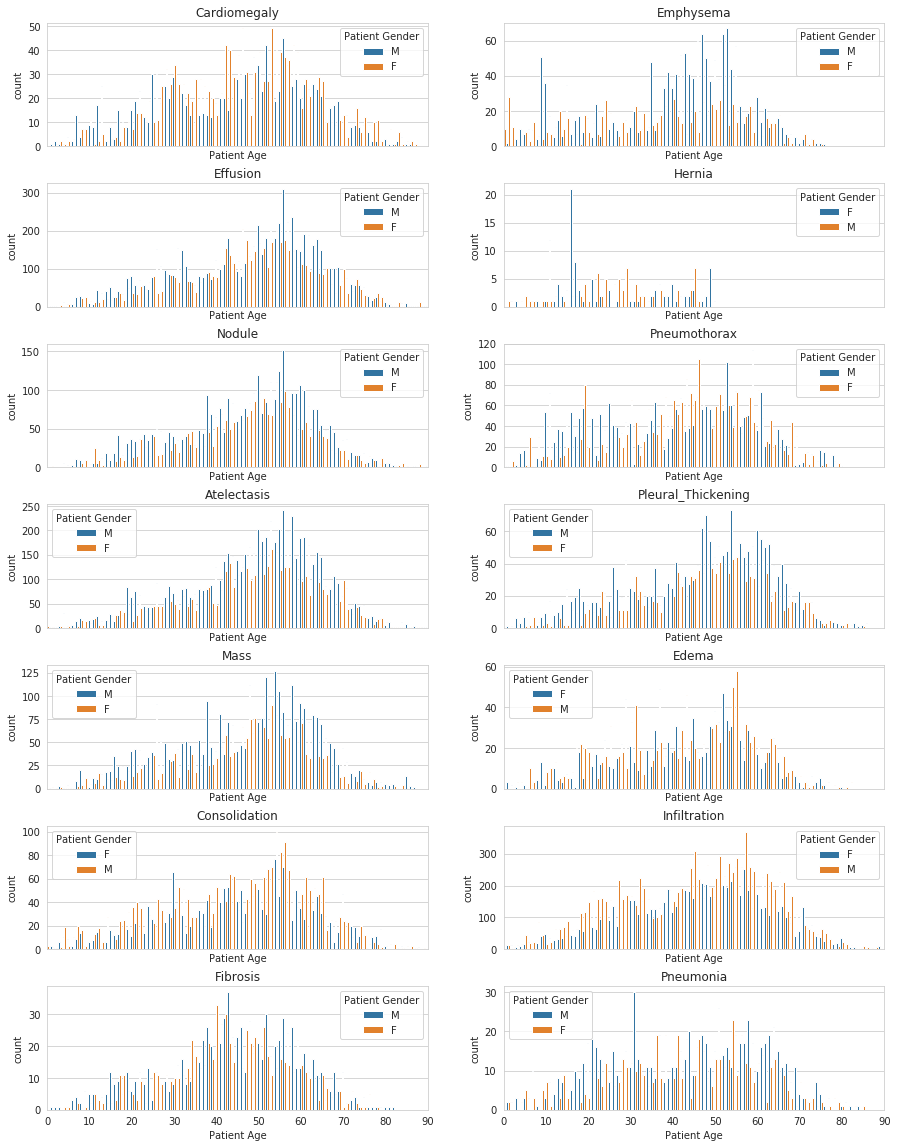

In [11]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = data[data['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

<h3> 3.3.3 No. of each disease by patient gender </h3>

In [12]:
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

In [13]:
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Labels_Count,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


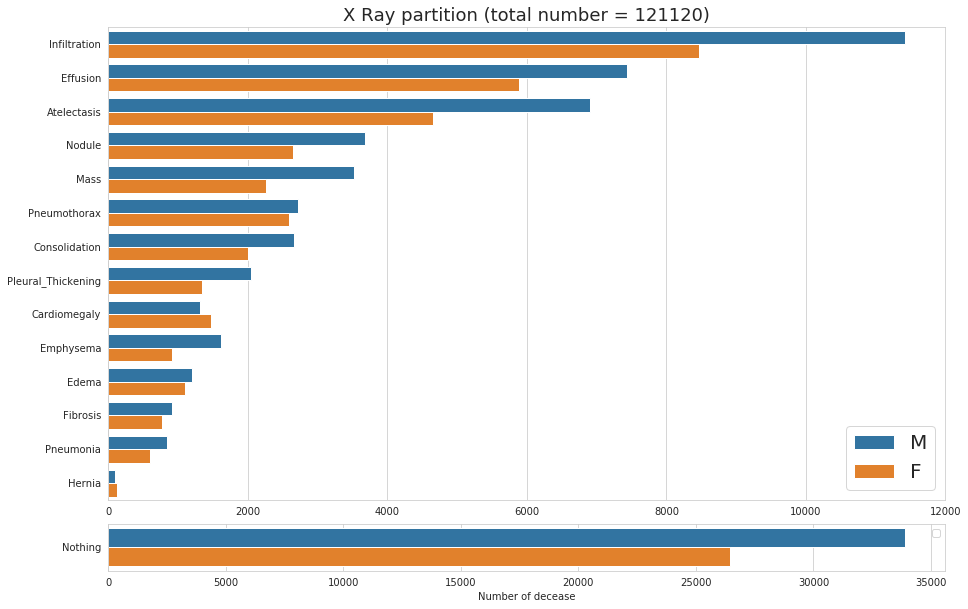

In [14]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

<h3> 3.3.5 ratio between one and multiple disease </h3>

In [16]:
df=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

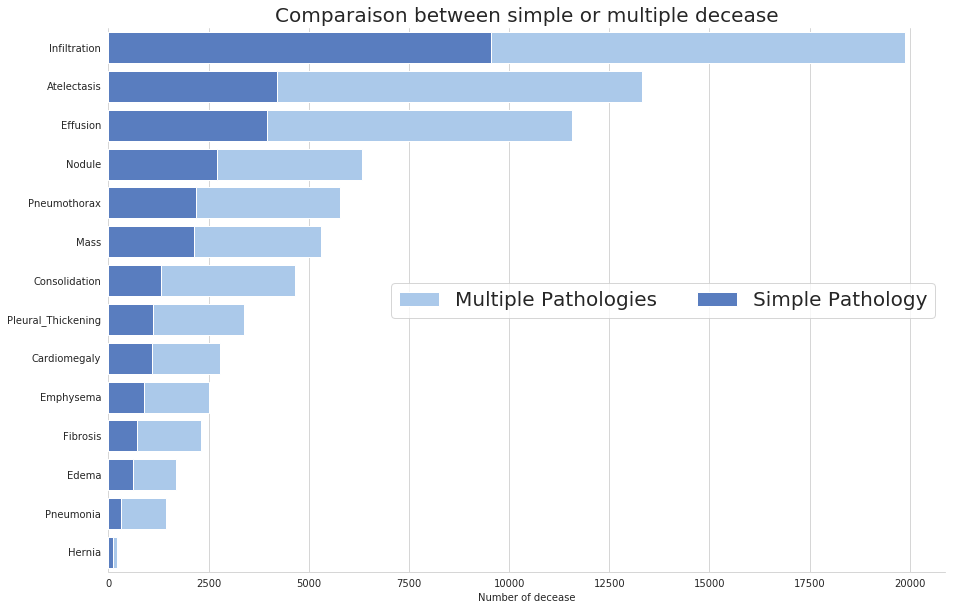

In [17]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

<h3> 3.3.6 Plot most important pathologies groups for each desease </h3>

In [18]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
Finding Labels,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,Effusion|Infiltration,0,0,1603,0,0,0,0,0,0,0,0,1603,0,0
Atelectasis|Infiltration,1350,Atelectasis|Infiltration,0,0,0,0,0,0,1350,0,0,0,0,1350,0,0
Atelectasis|Effusion,1165,Atelectasis|Effusion,0,0,1165,0,0,0,1165,0,0,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,0,0,829,0,0,0,0,0,0,829,0,0
Atelectasis|Effusion|Infiltration,737,Atelectasis|Effusion|Infiltration,0,0,737,0,0,0,737,0,0,0,0,737,0,0
Cardiomegaly|Effusion,484,Cardiomegaly|Effusion,484,0,484,0,0,0,0,0,0,0,0,0,0,0
Consolidation|Infiltration,441,Consolidation|Infiltration,0,0,0,0,0,0,0,0,0,0,441,441,0,0
Infiltration|Mass,418,Infiltration|Mass,0,0,0,0,0,0,0,0,418,0,0,418,0,0
Effusion|Pneumothorax,403,Effusion|Pneumothorax,0,0,403,0,0,403,0,0,0,0,0,0,0,0


#### we will apply MobileNet and DenseNet on this dataset